# Part2: Seq2Seq Machine Translation with Attention (Total: 50 Points)
## Objectives:
Implement a sequence-to-sequence model with attention to perform machine translation between two languages (e.g., English to French). This task will help you understand how con- ditioned generation works in the context of translating sequences from one domain to another, leveraging the power of LSTMs and attention mechanisms.

- Student Name: Lyle He

## This file is used to hyperparameter tuning and model selection.

In [3]:
import os
for dirname, _, filenames in os.walk('/kaggle/input'):
    for filename in filenames:
        print(os.path.join(dirname, filename))

/kaggle/input/nmt-model-1/nmt_model_1.pth
/kaggle/input/language-translation-englishfrench/eng_-french.csv


## Utility Functions

In [4]:
import re
from unidecode import unidecode
from nltk.tokenize import word_tokenize
from collections import Counter
from matplotlib import pyplot as plt

def clean_text(text):
    text = text.replace('\xa0', ' ')  # Replace non-breaking space with regular space
    text = text.replace('\u202f', ' ')  # Replace narrow non-breaking space with regular space
    text = re.sub('[\xad\u200b]', '', text)  # Remove soft hyphens and zero-width spaces
    text = unidecode(text)  # Remove accents
    text = text.lower()  # Convert to lowercase
    return text

def tokenize_and_add_special_tokens(text):
    tokens = word_tokenize(text)
    tokens = ['<SOS>'] + tokens + ['<EOS>']
    return tokens

def build_vocab_bidirectional(tokenized_texts):
    token_counts = Counter(token for text in tokenized_texts for token in text)

    # We start indexing from 2 to leave 0 and 1 for '<PAD>' and '<UNK>' tokens.
    vocab = {token: idx + 2 for idx, (token, count) in enumerate(token_counts.items())}
    vocab['<PAD>'] = 0
    vocab['<UNK>'] = 1
    # Inverse vocabulary
    inv_vocab = {idx: token for token, idx in vocab.items()}
    return vocab, inv_vocab

def tokens_to_sequence(tokens, vocab, maxlen=120, padding=True):
    if padding and len(tokens) <= maxlen:
        return [vocab.get(token, vocab['<UNK>']) for token in tokens] + [vocab['<PAD>']]*(maxlen-len(tokens))
    elif not padding:
        return [vocab.get(token, vocab['<UNK>']) for token in tokens]
    else:
        raise ValueError('Some lenght of tokens larger than the maxlen')
    

# plot the training and validation loss, losses_all_epoch = {'train': [], 'val': []}
    
def plot_training_validation_loss(losses_all_epoch):
    plt.plot(losses_all_epoch['train'], label='train')
    plt.plot(losses_all_epoch['val'], label='val')
    plt.xlabel('Epochs')
    plt.ylabel('Loss')
    plt.legend()
    plt.show()


## Data Preprocessing

In [5]:
# data preprocessing for the machine translation task
import numpy as np
import pandas as pd
import nltk

nltk.download('punkt')

filepaths = '/kaggle/input/language-translation-englishfrench/eng_-french.csv'

df = pd.read_csv(filepaths)
df.columns = ['en', 'fr']

print("number of samples", df.shape[0])
print("characters in English sentences\n", set("".join(df['en'].to_list())))
print("characters in French sentences\n", set("".join(df['fr'].to_list())))

print("length of Engish characters in English sentences", len(set("".join(df['en'].to_list()))))
print("length of French characters in French sentences", len(set("".join(df['fr'].to_list()))))

cleaned_df = df.map(clean_text)
print("Remove the unmeaningful character and convert to uppercase, and keep any meaningful characters")
print("length of en character set after cleaning", len(set("".join(cleaned_df['en']))))
print("length of fr character set after cleaning", len(set("".join(cleaned_df['fr']))))

# Apply tokenization to each sentence
print("Tokenize the sentences")
cleaned_df['en_tokens'] = cleaned_df['en'].apply(tokenize_and_add_special_tokens)
cleaned_df['fr_tokens'] = cleaned_df['fr'].apply(tokenize_and_add_special_tokens)

print("English-French pairs Examples")
for index, (en, fr) in enumerate(zip(cleaned_df['en'], cleaned_df['fr'])):
    if index > 5:
        break
    print(f'Src: {en}\tTgt: {fr}')

# Build the vocabulary
print("Build the vocabulary")
en_vocab, en_inv_vocab = build_vocab_bidirectional(cleaned_df['en_tokens'])
fr_vocab, fr_inv_vocab = build_vocab_bidirectional(cleaned_df['fr_tokens'])

# check the vocabulary content
print("English vocabulary Examples")
for index, (key, value) in enumerate(en_vocab.items()):
    if index > 20:
        break
    print(f'{key}\t: {value}')
print("French vocabulary Examples")
for index, (key, value) in enumerate(fr_vocab.items()):
    if index > 20:
        break
    print(f'{key}\t: {value}')

# Convert tokens to sequences
print("Convert tokens to sequences")
en_sequence = cleaned_df['en_tokens'].apply(tokens_to_sequence, args=(en_vocab, max(cleaned_df['en_tokens'].map(lambda x:len(x)).to_list()))).to_list()
fr_sequence = cleaned_df['fr_tokens'].apply(tokens_to_sequence, args=(fr_vocab, max(cleaned_df['fr_tokens'].map(lambda x:len(x)).to_list()))).to_list()

# check the sequence content
print("English sequence Examples")
for index, sequence in enumerate(en_sequence):
    if index > 5:
        break
    sentence = [en_inv_vocab.get(idx, "<UNK>") for idx in sequence if idx != en_vocab['<PAD>']]
    print(f'{sentence}')
    
print("French sequence Examples")
for index, sequence in enumerate(fr_sequence):
    if index > 5:
        break
    sentence = [fr_inv_vocab.get(idx, "<UNK>") for idx in sequence if idx != fr_vocab['<PAD>']]
    print(f'{sentence}')

# Summary of the data preprocessing
print("Summary of the data preprocessing")
print("length of en_vocab,", len(en_vocab))
print("length of fr_vocab,", len(fr_vocab))
print("number of samples - en_sequence: ", len(en_sequence))
print("number of samples - fr_sequence: ", len(fr_sequence))

print("data preprocessing done")

[nltk_data] Downloading package punkt to /usr/share/nltk_data...
[nltk_data]   Package punkt is already up-to-date!
number of samples 175621
characters in English sentences
 {'а', 'z', 't', 'o', 'Y', 'c', 'º', '0', 'O', 'm', '!', '1', 'v', '’', 'E', ',', '+', 'e', 'n', 's', 'u', 'F', 'q', '/', 'h', 'L', '2', ';', "'", 'b', '.', 'y', 'l', 'R', '5', 'T', 'H', 'X', '6', 'V', 'i', 'ú', '&', 'ç', '9', 'U', 'k', 'S', 'p', 'é', 'W', ' ', 'ö', 'Q', 'B', '"', '4', 'A', '₂', '$', 'P', 'w', '\xa0', '8', 'a', 'd', 'K', 'x', '\xad', 'Z', 'j', 'D', 'f', 'C', 'G', 'J', '?', '–', 'I', '—', '%', 'N', 'r', '‘', ':', 'g', '-', 'M', '3', '€', '7'}
characters in French sentences
 {'Ô', '…', 'z', 'œ', 't', 'o', 'Y', 'c', '0', 'O', 'm', '!', 'v', '’', '1', 'E', ',', '+', 'è', 'Ç', 'É', 's', 'e', 'n', 'u', 'F', 'q', 'ù', '/', 'h', 'L', '2', '\u2009', ';', "'", 'b', '.', 'y', 'l', '‽', 'R', '«', '\u202f', '5', 'T', 'H', 'X', '6', 'V', 'i', 'Ê', '&', 'ç', '(', 'á', '9', 'à', 'U', 'k', 'p', 'é', 'W', ' ', 'ö', '

## Seq2Seq Encoder-Decoder With Attention Model Definition


In [6]:
import torch
import torch.nn as nn
import torch.nn.functional as F
from torch.utils.data import Dataset

# create the dataset
class NMTDataset(Dataset):
    def __init__(self, src_data, tgt_data):
        self.src_data = src_data
        self.tgt_data = tgt_data

    def __len__(self):
        return len(self.src_data)

    def __getitem__(self, idx):
        return self.src_data[idx], self.tgt_data[idx]

class WordEmbeddingForTranlationTask(nn.Module): 
    """
    WordEmbeddingForTranlationTask: A simple word embedding model for the translation task.
    """
    def __init__(self, vocab_src, vocab_tgt, embed_size):
        """
        @param vocab_src (dict): Vocabulary for the source language
        @param vocab_tgt (dict): Vocabulary for the target language
        @param embed_size (int): Embedding size (dimensionality)
        """
        super(WordEmbeddingForTranlationTask, self).__init__()
        self.embed_size = embed_size

        src_pad_token_index = vocab_src['<PAD>']
        tgt_pad_token_index = vocab_tgt['<PAD>']

        self.source = nn.Embedding(len(vocab_src), embed_size, src_pad_token_index)
        self.target = nn.Embedding(len(vocab_tgt), embed_size, tgt_pad_token_index)

class NMTModel(nn.Module):
    """ Simple Neural Machine Translation Model:
        - Bidrectional LSTM Encoder
        - Unidirection LSTM Decoder
        - Global Attention Model (Luong, et al. 2015)
    """
    def __init__(self, vocab_src, vocab_tgt, embedding_dim, hidden_dim, dropout_rate=0.2, has_attention=True):
        """
        @param vocab_src : Vocabulary object containing src language, shape: (batch_size, src_sequence_length)
        @param vocab_tgt : Vocabulary object containing tgt language, shape: (batch_size, tgt_sequence_length)
        @param embedding_dim (int): Embedding size (dimensionality)
        @param hidden_dim (int): Hidden size (dimensionality)
        @param dropout_rate (float): Dropout rate
        """
        super(NMTModel, self).__init__()

        self.vocab_src = vocab_src
        self.vocab_tgt = vocab_tgt

        # model hyperparameters
        self.embedding_dim = embedding_dim
        self.hidden_dim = hidden_dim
        self.dropout_rate = dropout_rate
        self.has_attention = has_attention

        # nerual network layers
        self.embeddings = WordEmbeddingForTranlationTask(vocab_src, vocab_tgt, embedding_dim)
        self.encoder = nn.LSTM(embedding_dim, hidden_dim, bidirectional=True)
        self.decoder = nn.LSTMCell(embedding_dim+hidden_dim,hidden_dim)

        # projection layers
        self.encoder_hidden_to_initial_decoder_hidden = nn.Linear(hidden_dim*2, hidden_dim, bias=False)
        self.encoder_cell_to_initial_decoder_cell = nn.Linear(hidden_dim*2, hidden_dim, bias=False)
        self.encoder_hidden_to_decoder_hidden_for_attention = nn.Linear(hidden_dim*2, hidden_dim, bias=False)

        if self.has_attention:
            self.combined_output_and_hidden_to_hidden = nn.Linear(hidden_dim*3, hidden_dim, bias=False)
        else:
            self.combined_output_and_hidden_to_hidden = nn.Linear(hidden_dim, hidden_dim, bias=False)
        
        self.target_vocab_projection = nn.Linear(hidden_dim, len(vocab_tgt), bias=False)
        self.dropout = nn.Dropout(dropout_rate)        
    
    def forward(self, input_sequences, target_sequences):
        """
        @param input_sequence (torch.Tensor): input sequence of word indices, shape: (batch_size, src_sequence_length)
        @param target_sequence (torch.Tensor): target sequence of word indices, shape: (batch_size, tgt_sequence_length)
        """

        # transpose the input sequence and target sequence
        input_sequences = torch.t(input_sequences) # shape: (src_sequence_length, batch_size)
        target_sequences = torch.t(target_sequences) # shape: (tgt_sequence_length, batch_size)
        
        # encoder computation
        encoder_hiddens, (last_hidden, last_cell) = self.encode(input_sequences)

        # last hidden and cell projection
        initial_decoder_hidden = self.encoder_hidden_to_initial_decoder_hidden(last_hidden)
        initial_decoder_cell = self.encoder_cell_to_initial_decoder_cell(last_cell)

        # decoder computation
        combined_outputs = self.decode(target_sequences, encoder_hiddens, initial_decoder_hidden, initial_decoder_cell)
        
        # project the combined outputs to the target vocabulary
        combined_outputs = self.dropout(combined_outputs)
        combined_outputs = self.target_vocab_projection(combined_outputs)
        P = F.log_softmax(combined_outputs, dim=-1)

        # target mask
        target_mask = (target_sequences != self.vocab_tgt['<PAD>']).float()

        # Compute log probability of generating true target words
        target_sequences = target_sequences[1:]
        target_mask = target_mask[1:]

        target_gold_words_log_prob = torch.gather(P, dim=-1, index=target_sequences.unsqueeze(-1)).squeeze(-1) #* target_mask
        scores = target_gold_words_log_prob.sum(dim=0)

        return scores

    def encode(self, input_sequence):
        """
        @param input_sequence (torch.Tensor): input sequence of word indices, shape: (src_sequence_length, batch_size)
        @return encoder_hiddens (torch.Tensor): output of the encoder (the excat hidden states of each time step)
        @return last_hidden (torch.Tensor): last hidden state of the encoder
        @return last_cell (torch.Tensor): last cell state of the encoder
        """
        # word embedding
        embeddings = self.embeddings.source(input_sequence) # shape: (src_sequence_length, batch_size, embedding_dim)

        # encoder computation
        encoder_hiddens, (last_hidden, last_cell) = self.encoder(embeddings)

        encoder_hiddens = torch.permute(encoder_hiddens,(1, 0, 2)) # shape: (batch_size, src_sequence_length, hidden_dim*2)

        # since the encoder is bidirectional, we need to concatenate the forward and backward hidden states
        last_hidden = torch.cat((last_hidden[0], last_hidden[1]), dim=1) # dim=1 to concatenate along the column
        last_cell = torch.cat((last_cell[0], last_cell[1]), dim=1)

        return encoder_hiddens, (last_hidden, last_cell)

    def decode(self, target_sequence, encoder_hiddens, initial_decoder_hidden, initial_decoder_cell):
        """
        @param target_sequence (torch.Tensor): target sequence of word indices, shape: (tgt_sequence_length, batch_size)
        @param encoder_hiddens (torch.Tensor): output of the encoder (the excat hidden states of each time step)
        @param initial_decoder_hidden (torch.Tensor): initial hidden state of the decoder
        @param initial_decoder_cell (torch.Tensor): initial cell state of the decoder
        """
        
        # Initialize a previous Output
        batch_size = encoder_hiddens.size(0)
        prev_output = torch.zeros(batch_size, self.hidden_dim, device=self.device)

        # decoder hidden and cell states
        decoder_hidden_t = initial_decoder_hidden
        decoder_cell_t = initial_decoder_cell
        
        # word embedding
        embeddings = self.embeddings.target(target_sequence) # shape: (tgt_sequence_length, batch_size, embedding_dim)

        # encoder hidden states for attention computation
        encoder_hiddens_for_attention = self.encoder_hidden_to_decoder_hidden_for_attention(encoder_hiddens)
        
        # decoder computation
        combined_outputs = []

        for word_embedding_at_t in torch.split(embeddings, 1, dim=0):
            # shape of word_at_t: (1, batch_size, embedding_dim)
            word_embedding_at_t = word_embedding_at_t.squeeze(0) # remove the dimension of 0
            # shape of word_at_t: (batch_size, embedding_dim)

            word_embedding_cat_prev_output_at_t = torch.cat((word_embedding_at_t, prev_output), dim=1)

            # lstm cell computation and attention computation
            combined_output_t,  dec_state, _ = self.step(word_embedding_cat_prev_output_at_t, encoder_hiddens, encoder_hiddens_for_attention, decoder_hidden_t, decoder_cell_t)
            decoder_hidden_t, decoder_cell_t = dec_state
            combined_outputs.append(combined_output_t)
            prev_output = combined_output_t
        combined_outputs = torch.stack(combined_outputs) 

        return combined_outputs
    
    def step(self, features_t, encoder_hiddens, encoder_hiddens_for_attention, prev_hidden, prev_cell):
        """
        1. input the features into LSTM cell and get the hidden state and cell state
        2. compute the attention score
        3. compute the context vector
        4. compute the combined output

        @param features_t (torch.Tensor): input features, shape: (batch_size, feature_dim)
        @param encoder_hiddens (torch.Tensor): output of the encoder (the excat hidden states of each time step), shape: (batch_size, src_sequence_length, hidden_dim)
        @param encoder_hiddens_for_attention, shape: (batch_size, src_sequence_length, hidden_dim)
        @param prev_hidden (torch.Tensor): previous hidden state of the decoder
        @param prev_cell (torch.Tensor): previous cell state of the decoder
        """
        decoder_hidden_t, decoder_cell_t = self.decoder(features_t, (prev_hidden, prev_cell)) # shape of decoder_hidden_t: (batch_size, hidden_dim)

        if self.has_attention:
            # compute the attention score, use encoder_hidden_t to dot product with encoder_hiddens_for_attention
            attention_score = torch.bmm(decoder_hidden_t.unsqueeze(1), encoder_hiddens_for_attention.permute(0, 2, 1)).squeeze(1) # shape: (batch_size, src_sequence_length)
            attention_score_after_softmax = torch.softmax(attention_score, dim=1)

            # (batch_size, 1, src_sequence_length) * (batch_size, src_sequence_length, hidden_dim*2) -> (batch_size, 1, hidden_dim*2)
            src_context_vector = torch.bmm(attention_score_after_softmax.unsqueeze(1), encoder_hiddens).squeeze(1)
        

            # concatenate the output of the decoder and the context vector
            combined_output = torch.cat((decoder_hidden_t, src_context_vector), dim=1)

            # project the combined output to the hidden_dim
            final_features = self.combined_output_and_hidden_to_hidden(combined_output)

            return final_features, (decoder_hidden_t, decoder_cell_t), attention_score_after_softmax

        else:
            combined_output = decoder_hidden_t
            # project the combined output to the hidden_dim
            final_features = self.combined_output_and_hidden_to_hidden(combined_output)
            return final_features, (decoder_hidden_t, decoder_cell_t), 0

    def test(self, input_sequence, end_token_index, max_length=50, is_just_one_sentence=False):
        """
        @param input_sequence (torch.Tensor): input sequence of word indices, shape: (src_sequence_length, batch_size)
        @param max_length (int): maximum length of the target sequence
        @return decoded_words (list): list of words in the target language
        """
        input_sequence = torch.t(input_sequence) # shape: (src_sequence_length, batch_size)
        batch_size = input_sequence.size(1)
        encoder_hiddens, (last_hidden, last_cell) = self.encode(input_sequence)
        prev_output = torch.zeros(batch_size, self.hidden_dim, device=self.device)
        decoder_hidden_t = self.encoder_hidden_to_initial_decoder_hidden(last_hidden)
        decoder_cell_t = self.encoder_cell_to_initial_decoder_cell(last_cell)
        encoder_hiddens_for_attention = self.encoder_hidden_to_decoder_hidden_for_attention(encoder_hiddens)    
        
        decoded_words = []
        # torch.tensor([self.vocab_tgt['<SOS>']]
        first_word_index = torch.tensor([self.vocab_tgt['<SOS>']] * batch_size, device=self.device).unsqueeze(0)
        word_embedding_at_t = self.embeddings.target(first_word_index).squeeze(0) # shape: (batch_size, embedding_dim)

        attention_record = []
        for _ in range(max_length):
            word_embedding_cat_prev_output_at_t = torch.cat((word_embedding_at_t, prev_output), dim=1)
            combined_output_t, (decoder_hidden_t, decoder_cell_t), attention_score_after_softmax = self.step(word_embedding_cat_prev_output_at_t, encoder_hiddens, encoder_hiddens_for_attention, decoder_hidden_t, decoder_cell_t)
            combined_output_t = self.dropout(combined_output_t)
            prev_output = combined_output_t

            combined_output_t = self.target_vocab_projection(combined_output_t)
            P = F.log_softmax(combined_output_t, dim=-1)
            word_index = torch.argmax(P, dim=-1)

            if is_just_one_sentence and word_index.item() == end_token_index:
                break
            
            word_embedding_at_t = self.embeddings.target(word_index)
            
            # word_index is a tensor, shape: ([batch_size])
            decoded_words.append(word_index)
            
            if self.has_attention:
                attention_record.append(attention_score_after_softmax)
        
        if self.has_attention:
            attention_record = torch.stack(attention_record)
        decoded_words = torch.stack(decoded_words) 
        return decoded_words, attention_record
    
    @property
    def device(self):
        """
        @return device (torch.device): device on which the model is located
        """
        return self.embeddings.source.weight.device
    


## Train and Test Function

In [7]:
# train function display the training process for each epoch
def train_NMTModel(model, train_loader, optimizer, device, epochs):
    model.to(device)
    model.train()
    for epoch in range(epochs):
        total_loss = 0
        trained_samples = 0
        progress_bar = tqdm(train_loader, desc=f"Epoch {epoch+1}", leave=False)
        for i, (src, tgt) in enumerate(progress_bar):
            src = src.to(device)
            tgt = tgt.to(device)
            optimizer.zero_grad()
            batch_size = src.shape[0]

            example_losses = -model(src, tgt)
            batch_loss = example_losses.sum()
            loss = batch_loss / batch_size

            loss.backward()
            optimizer.step()

            trained_samples += batch_size
            total_loss += batch_loss.item()
            progress_bar.set_postfix({'loss': total_loss / trained_samples})
        if trained_samples > 0:
            print(f'Epoch {epoch+1}, Average Loss: {total_loss / trained_samples}')
        else:
            print(f'Epoch {epoch+1}, Total Loss: {total_loss}')

# train and validation function
def train_val_NMTModel(model, train_loader, val_loader, optimizer, device, epochs):
    """
    stored the loss for each epoch for plotting
    """
    losses_all_epoch = {'train': [], 'val': []}
    model.to(device)
    model.train()
    for epoch in range(epochs):
        model.train()
        total_loss = 0
        trained_samples = 0
        progress_bar = tqdm(train_loader, desc=f"Epoch {epoch+1}", leave=False)
        for src, tgt in progress_bar:
            src = src.to(device)
            tgt = tgt.to(device)
            optimizer.zero_grad()
            batch_size = src.shape[0]

            example_losses = -model(src, tgt)
            batch_loss = example_losses.sum()
            loss = batch_loss / batch_size

            loss.backward()
            optimizer.step()

            trained_samples += batch_size
            total_loss += batch_loss.item()
            progress_bar.set_postfix({'Average Loss': total_loss / trained_samples})
        losses_all_epoch['train'].append(total_loss / trained_samples)
        if trained_samples > 0:
            print(f'Epoch {epoch+1}, Average Train Loss: {total_loss / trained_samples}', end=', ')
        else:
            print(f'Epoch {epoch+1}, Total Train Loss: {total_loss}', end=',')
        
        # validation
        model.eval()
        with torch.no_grad():
            total_val_loss = 0
            val_samples = 0
            for src, tgt in val_loader:
                src = src.to(device)
                tgt = tgt.to(device)
                batch_size = src.shape[0]
                example_losses = -model(src, tgt)
                batch_loss = example_losses.sum()
                val_samples += batch_size
                total_val_loss += batch_loss.item()
            if val_samples > 0:
                losses_all_epoch['val'].append(total_val_loss / val_samples)
                print(f'Epoch {epoch+1}, Average Val Loss: {total_val_loss / val_samples}')
            else:
                print(f'Epoch {epoch+1}, Total Val Loss: {total_val_loss}')
        model.train()
    return losses_all_epoch

# define a function to test the model with a sentence
def test_model(model, sentence, fr_inv_vocab, device, max_length=50):
    model.eval()
    if len(sentence.split()) > max_length:
        raise ValueError('The length of the sentence is larger than the max_length')
    with torch.no_grad():
        # tokenize the sentence
        en_vocab = model.vocab_src
        fr_vocab = model.vocab_tgt
        sequence = tokens_to_sequence(tokenize_and_add_special_tokens(clean_text(sentence)), en_vocab, padding=False)
        # convert the sequence to tensor
        src = torch.tensor(sequence, dtype=torch.long).to(device)
        # add the batch dimension
        src = src.unsqueeze(0)
        # get the predictions
        decoded_words, attention = model.test(src, end_token_index=fr_vocab['<EOS>'], is_just_one_sentence=True)
        # convert the tensor to a list
        decoded_words = decoded_words.squeeze(1).tolist()
        predict_sentence = [fr_inv_vocab.get(idx, '<UNK>') for idx in decoded_words]
        return " ".join(predict_sentence)

def test_model_bleu(model, test_loader, device):
    model.eval()
    fr_vocab = model.vocab_tgt
    from nltk.translate.bleu_score import sentence_bleu, SmoothingFunction
    with torch.no_grad():
        scores = 0
        for i, (src, tgt) in enumerate(test_loader):
            src = src.to(device)
            tgt = tgt.to(device)
            batch_size = src.shape[0]
            predicted_target_indices, attention_record = model.test(src, end_token_index=fr_vocab['<EOS>'])
            # transpose the predicted_target_indices to (batch_size, max_length)
            predicted_target_indices = predicted_target_indices.transpose(0, 1)
            # convert tensor to list
            predicted_target_indices = predicted_target_indices.tolist()
            tgt_indices = tgt.tolist()
            # get the <EOS> token index
            eos_index = fr_vocab['<EOS>']
            # remove the <EOS> token and the tokens after it of the predicted_target_indices
            for row in range(batch_size):
                if eos_index in predicted_target_indices[row]:
                    first_predicted_eos_index = predicted_target_indices[row].index(eos_index)
                    predicted_target_indices[row] = predicted_target_indices[row][:first_predicted_eos_index]
                if eos_index in tgt_indices[row]:
                    first_tgt_eos_index = tgt_indices[row].index(eos_index)
                    tgt_indices[row] = [tgt_indices[row][:first_tgt_eos_index]]
            chencherry = SmoothingFunction()
            # calculate the bleu score
            bleu_scores = [sentence_bleu(refs, pred,smoothing_function=chencherry.method1) for refs, pred in zip(tgt_indices, predicted_target_indices)]
            scores += sum(bleu_scores)/len(bleu_scores)
        return scores / len(test_loader)

## Load Data and Prepare for Training

In [8]:
import torch
import torch.optim as optim
import torch.nn as nn
from torch.utils.data import Dataset, DataLoader
from sklearn.model_selection import train_test_split
from tqdm import tqdm
# from data_preprocessing import en_sequence, fr_sequence, en_vocab, fr_vocab, en_inv_vocab, fr_inv_vocab
# from model import NMTModel, NMTDataset

In [9]:
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
print(f'device: {device}')

device: cuda


In [59]:
# create the dataset
src_data_tensor = torch.tensor(en_sequence, dtype=torch.long).to(device)
tgt_data_tensor = torch.tensor(fr_sequence, dtype=torch.long).to(device)

# split the data, since the data is to much we get 20% for training, and 2% for testing
temp_src_tensor, _, temp_tgt_tensor, _ = train_test_split(src_data_tensor, tgt_data_tensor, test_size=0.5, random_state=42)
train_src_tensor, temp_src_tensor, train_tgt_tensor, temp_tgt_tensor = train_test_split(temp_src_tensor, temp_tgt_tensor, test_size=0.2, random_state=42)

# check the data
print(f'train_loader check')
for i, (src, tgt) in enumerate(train_loader):
    print(f'src: {src.shape}, tgt: {tgt.shape}')
    if i > 5:
        break

train_loader check
src: torch.Size([128, 53]), tgt: torch.Size([128, 61])
src: torch.Size([128, 53]), tgt: torch.Size([128, 61])
src: torch.Size([128, 53]), tgt: torch.Size([128, 61])
src: torch.Size([128, 53]), tgt: torch.Size([128, 61])
src: torch.Size([128, 53]), tgt: torch.Size([128, 61])
src: torch.Size([128, 53]), tgt: torch.Size([128, 61])
src: torch.Size([128, 53]), tgt: torch.Size([128, 61])


## Start Hyperparameter Grid Search basic

In [45]:
# define a function to test different hyperparameters
def test_hyperparameters(grid_search_train_dataset, grid_search_val_dataset, batch_size, embedding_dim, hidden_dim, dropout, epochs=10):
    grid_search_train_loader = DataLoader(grid_search_train_dataset, batch_size=batch_size, shuffle=False)
    grid_search_val_loader = DataLoader(grid_search_val_dataset, batch_size=batch_size, shuffle=False)

    # create the model
    model = NMTModel(en_vocab, fr_vocab, embedding_dim, hidden_dim, dropout)
    model.to(device)
    model.train()

    # create the optimizer
    optimizer = optim.Adam(model.parameters(), lr=0.001)

    # train and validation
    losses_all_epoch = train_val_NMTModel(model, grid_search_train_loader, grid_search_val_loader, optimizer, device, epochs)
    return losses_all_epoch
def plot_training_validation_loss_hyperparameters(title, losses_all_epoch_list, hyperparameters_names, hyperparameters_values):
    for i, losses_all_epoch in enumerate(losses_all_epoch_list):
        plt.plot(losses_all_epoch['train'], label=f'train {hyperparameters_names}: {hyperparameters_values[i]}', linestyle='--')
    plt.xlabel('Epochs')
    plt.ylabel('Loss')
    plt.title(title)
    plt.legend()
    plt.show()
    
    for i, losses_all_epoch in enumerate(losses_all_epoch_list):
        plt.plot(losses_all_epoch['val'], label=f'val {hyperparameters_names}: {hyperparameters_values[i]}', linestyle='-')
    plt.xlabel('Epochs')
    plt.ylabel('Loss')
    plt.title(title)
    plt.legend()
    plt.show()

In [34]:
# use less data for hyperparameters grid search
src_temp_data_grid, _, tgt_temp_data_grid, _ = train_test_split(train_src_tensor, train_tgt_tensor, test_size=0.95, random_state=42)
grid_search_train_src_tensor, grid_test_search_src_tensor, grid_search_train_tgt_tensor, grid_test_search_tgt_tensor = train_test_split(src_temp_data_grid, tgt_temp_data_grid, test_size=0.1, random_state=42)
print("src grid search train data sample number: ", len(grid_search_train_src_tensor))
print("tgt grid search train data sample number: ", len(grid_search_train_tgt_tensor))
print("src grid test search data sample number: ", len(grid_test_search_src_tensor))
print("tgt grid test search data sample number: ", len(grid_test_search_tgt_tensor))
grid_search_train_dataset = NMTDataset(grid_search_train_src_tensor, grid_search_train_tgt_tensor)
grid_search_val_dataset = NMTDataset(val_src_tensor, val_tgt_tensor)

src grid search train data sample number:  3160
tgt grid search train data sample number:  3160
src grid test search data sample number:  352
tgt grid test search data sample number:  352


In [46]:
embedding_dim = 128
hidden_dim = 128
dropout = 0.1
batch_sizes = [32, 64, 128, 256]
losses = []
for batch in batch_sizes:
    losses_all_epoch = test_hyperparameters(grid_search_train_dataset, grid_search_val_dataset, batch, embedding_dim, hidden_dim, dropout,epochs=20)
    losses.append(losses_all_epoch)

Epoch 1, Average Train Loss: 120.46048784859573, Epoch 1, Average Val Loss: 53.18389953050265


Epoch 2, Average Train Loss: 47.829589727860466, Epoch 2, Average Val Loss: 47.50990218082276


Epoch 3, Average Train Loss: 43.644001905223995, Epoch 3, Average Val Loss: 45.85502088082134


Epoch 4, Average Train Loss: 41.320522086227996, Epoch 4, Average Val Loss: 44.70983667767899


Epoch 5, Average Train Loss: 39.37975409785403, Epoch 5, Average Val Loss: 43.73256413744653


Epoch 6, Average Train Loss: 37.49139692089226, Epoch 6, Average Val Loss: 42.83253733230172


Epoch 7, Average Train Loss: 35.754673921609225, Epoch 7, Average Val Loss: 42.510505359138335


Epoch 8, Average Train Loss: 34.22854832516441, Epoch 8, Average Val Loss: 41.3963560141948


Epoch 9, Average Train Loss: 32.45183657875544, Epoch 9, Average Val Loss: 40.81980300484533


Epoch 10, Average Train Loss: 30.707221946233435, Epoch 10, Average Val Loss: 40.80806714540027


Epoch 11, Average Train Loss: 29.204105174390577, Epoch 11, Average Val Loss: 41.346234487436476


Epoch 12, Average Train Loss: 27.918966095357003, Epoch 12, Average Val Loss: 40.73319655091382


Epoch 13, Average Train Loss: 26.158644046059138, Epoch 13, Average Val Loss: 40.888012388086224


Epoch 14, Average Train Loss: 24.500150308729726, Epoch 14, Average Val Loss: 40.92056093345184


Epoch 15, Average Train Loss: 22.87827768446524, Epoch 15, Average Val Loss: 41.650978622723244


Epoch 16, Average Train Loss: 21.31256418348868, Epoch 16, Average Val Loss: 41.69029355915271


Epoch 17, Average Train Loss: 19.75649683505674, Epoch 17, Average Val Loss: 42.52092920600275


Epoch 18, Average Train Loss: 18.034918299807778, Epoch 18, Average Val Loss: 42.767851493825894


Epoch 19, Average Train Loss: 16.14418555151058, Epoch 19, Average Val Loss: 43.354986967767324


Epoch 20, Average Train Loss: 14.72830297735673, Epoch 20, Average Val Loss: 44.21060446880494


Epoch 1, Average Train Loss: 183.7245878195461, Epoch 1, Average Val Loss: 70.8790660285146


Epoch 2, Average Train Loss: 57.13983957797666, Epoch 2, Average Val Loss: 51.27436368295183


Epoch 3, Average Train Loss: 47.42159126378313, Epoch 3, Average Val Loss: 47.98276883911508


Epoch 4, Average Train Loss: 44.74159120970135, Epoch 4, Average Val Loss: 46.97642557578374


Epoch 5, Average Train Loss: 43.379069808766815, Epoch 5, Average Val Loss: 46.32737693877851


Epoch 6, Average Train Loss: 42.238476311406004, Epoch 6, Average Val Loss: 45.67173041597937


Epoch 7, Average Train Loss: 40.98069832717316, Epoch 7, Average Val Loss: 44.84536478685336


Epoch 8, Average Train Loss: 39.67980918401404, Epoch 8, Average Val Loss: 44.18135556489375


Epoch 9, Average Train Loss: 38.345298361476466, Epoch 9, Average Val Loss: 43.598221316965876


Epoch 10, Average Train Loss: 37.22757888987095, Epoch 10, Average Val Loss: 43.18558902825192


Epoch 11, Average Train Loss: 36.30848104742509, Epoch 11, Average Val Loss: 42.83017120343951


Epoch 12, Average Train Loss: 35.01159949966624, Epoch 12, Average Val Loss: 42.13808400239153


Epoch 13, Average Train Loss: 33.83698659003535, Epoch 13, Average Val Loss: 42.01275508955771


Epoch 14, Average Train Loss: 32.87043182759346, Epoch 14, Average Val Loss: 42.055737216412076


Epoch 15, Average Train Loss: 32.06294505445263, Epoch 15, Average Val Loss: 41.6806726745668


Epoch 16, Average Train Loss: 31.120156396793412, Epoch 16, Average Val Loss: 41.58103487071029


Epoch 17, Average Train Loss: 30.335054672820657, Epoch 17, Average Val Loss: 41.82941518005295


Epoch 18, Average Train Loss: 29.40520046572142, Epoch 18, Average Val Loss: 41.75097802912316


Epoch 19, Average Train Loss: 28.564789030823526, Epoch 19, Average Val Loss: 41.333662527675386


Epoch 20, Average Train Loss: 27.297990649259543, Epoch 20, Average Val Loss: 41.497177563662845


Epoch 1, Average Train Loss: 278.7199516972409, Epoch 1, Average Val Loss: 87.78830135733402


Epoch 2, Average Train Loss: 77.73739770816852, Epoch 2, Average Val Loss: 72.43789391690866


Epoch 3, Average Train Loss: 63.18420255636867, Epoch 3, Average Val Loss: 57.09119532317646


Epoch 4, Average Train Loss: 51.66655512942543, Epoch 4, Average Val Loss: 51.28095150395741


Epoch 5, Average Train Loss: 47.69703724535206, Epoch 5, Average Val Loss: 49.33477749144104


Epoch 6, Average Train Loss: 45.878772281695014, Epoch 6, Average Val Loss: 48.23416653098665


Epoch 7, Average Train Loss: 44.53814542746242, Epoch 7, Average Val Loss: 47.43859147346721


Epoch 8, Average Train Loss: 43.50312330028679, Epoch 8, Average Val Loss: 46.92840582427613


Epoch 9, Average Train Loss: 42.675088539606406, Epoch 9, Average Val Loss: 46.50209164095419


Epoch 10, Average Train Loss: 41.90726047950455, Epoch 10, Average Val Loss: 46.07566285250114


Epoch 11, Average Train Loss: 41.07852087865902, Epoch 11, Average Val Loss: 45.70552003037453


Epoch 12, Average Train Loss: 40.2406313352947, Epoch 12, Average Val Loss: 45.378805379690526


Epoch 13, Average Train Loss: 39.49329447685918, Epoch 13, Average Val Loss: 44.89053197021624


Epoch 14, Average Train Loss: 38.826543571375595, Epoch 14, Average Val Loss: 44.457352683750784


Epoch 15, Average Train Loss: 38.105367694323576, Epoch 15, Average Val Loss: 44.30923325330436


Epoch 16, Average Train Loss: 37.48163506230222, Epoch 16, Average Val Loss: 44.07976567170952


Epoch 17, Average Train Loss: 36.67435488157634, Epoch 17, Average Val Loss: 43.9740213911784


Epoch 18, Average Train Loss: 36.042826360388645, Epoch 18, Average Val Loss: 44.02568545100928


Epoch 19, Average Train Loss: 35.49002932777888, Epoch 19, Average Val Loss: 43.93957926849341


Epoch 20, Average Train Loss: 35.17706376087816, Epoch 20, Average Val Loss: 43.78279369385961


Epoch 1, Average Train Loss: 431.18128646657436, Epoch 1, Average Val Loss: 115.03914913502875


Epoch 2, Average Train Loss: 108.4915518072587, Epoch 2, Average Val Loss: 79.48638862494306


Epoch 3, Average Train Loss: 78.87971052338806, Epoch 3, Average Val Loss: 76.29112756101597


Epoch 4, Average Train Loss: 73.19133609820015, Epoch 4, Average Val Loss: 72.23956954290513


Epoch 5, Average Train Loss: 68.07673308939873, Epoch 5, Average Val Loss: 66.69748438122794


Epoch 6, Average Train Loss: 60.22989764636076, Epoch 6, Average Val Loss: 58.768160381345375


Epoch 7, Average Train Loss: 54.62453180626978, Epoch 7, Average Val Loss: 54.96188503587291


Epoch 8, Average Train Loss: 51.239725465412384, Epoch 8, Average Val Loss: 52.34677644292364


Epoch 9, Average Train Loss: 48.88396428748022, Epoch 9, Average Val Loss: 50.746675756115835


Epoch 10, Average Train Loss: 47.36998816381527, Epoch 10, Average Val Loss: 49.65108103611491


Epoch 11, Average Train Loss: 46.216197957871834, Epoch 11, Average Val Loss: 48.830897042887344


Epoch 12, Average Train Loss: 45.28415650959256, Epoch 12, Average Val Loss: 48.1610329431087


Epoch 13, Average Train Loss: 44.440633807604826, Epoch 13, Average Val Loss: 47.60929298031616


Epoch 14, Average Train Loss: 43.74424508010285, Epoch 14, Average Val Loss: 47.14814906874573


Epoch 15, Average Train Loss: 43.150234174124805, Epoch 15, Average Val Loss: 46.77086158146851


Epoch 16, Average Train Loss: 42.5936722767504, Epoch 16, Average Val Loss: 46.444587140158795


Epoch 17, Average Train Loss: 42.049965696696994, Epoch 17, Average Val Loss: 46.156358627425334


Epoch 18, Average Train Loss: 41.6026448310176, Epoch 18, Average Val Loss: 45.90197877630858


Epoch 19, Average Train Loss: 41.12704274624209, Epoch 19, Average Val Loss: 45.68440555024698


Epoch 20, Average Train Loss: 40.710262018517604, Epoch 20, Average Val Loss: 45.43915001361249


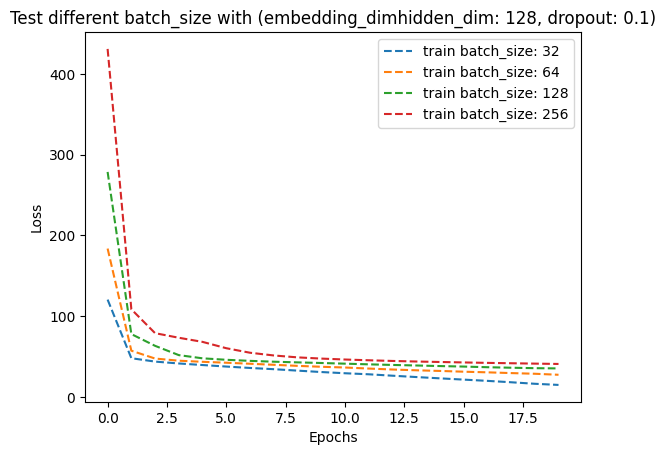

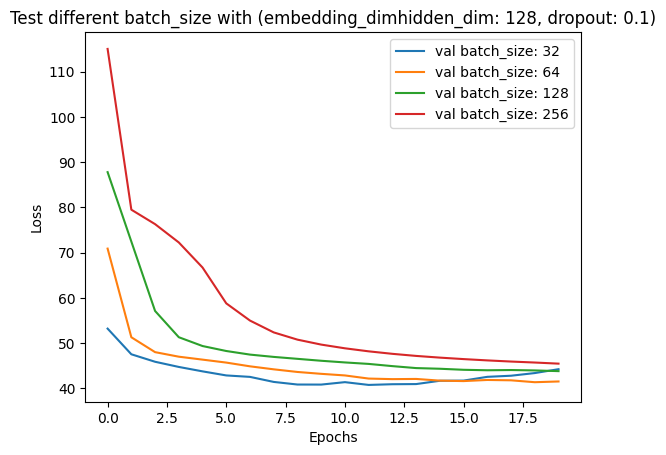

In [47]:
title = "Test different batch_size with (embedding_dimhidden_dim: 128, dropout: 0.1)"
plot_training_validation_loss_hyperparameters(title, losses, 'batch_size', batch_sizes)

As we can see, the test of different batch size in a small subset of train dataset can not turn out anything,since as the epoch increase the loss will decrease

Here I choose 128 as my best batch size

In [57]:
embedding_dims = [128, 256, 512]
hidden_dim = 128
dropout = 0.1
batch_size = 128
losses = []
for embedding_dim in embedding_dims:
    losses_all_epoch = test_hyperparameters(grid_search_train_dataset, grid_search_val_dataset, batch_size, embedding_dim, hidden_dim, dropout, epochs=15)
    losses.append(losses_all_epoch)

Epoch 1, Average Train Loss: 268.2516374419007, Epoch 1, Average Val Loss: 82.76267573898902


Epoch 2, Average Train Loss: 77.01319147423852, Epoch 2, Average Val Loss: 72.98872988376894


Epoch 3, Average Train Loss: 66.22447386150118, Epoch 3, Average Val Loss: 60.62135838164432


Epoch 4, Average Train Loss: 53.41918141811709, Epoch 4, Average Val Loss: 51.92954937329176


Epoch 5, Average Train Loss: 48.06584325862836, Epoch 5, Average Val Loss: 49.574395356451426


Epoch 6, Average Train Loss: 45.98521612626088, Epoch 6, Average Val Loss: 48.34284972970761


Epoch 7, Average Train Loss: 44.578533394729035, Epoch 7, Average Val Loss: 47.451455023630565


Epoch 8, Average Train Loss: 43.45867556801325, Epoch 8, Average Val Loss: 46.84821965571974


Epoch 9, Average Train Loss: 42.53783430268493, Epoch 9, Average Val Loss: 46.36181751838131


Epoch 10, Average Train Loss: 41.665651731853245, Epoch 10, Average Val Loss: 46.00567384369484


Epoch 11, Average Train Loss: 40.863369635087025, Epoch 11, Average Val Loss: 45.789515248654766


Epoch 12, Average Train Loss: 40.14345587235463, Epoch 12, Average Val Loss: 45.37172908281197


Epoch 13, Average Train Loss: 39.56690511582773, Epoch 13, Average Val Loss: 45.25750063057845


Epoch 14, Average Train Loss: 39.11885298716871, Epoch 14, Average Val Loss: 45.236334964607536


Epoch 15, Average Train Loss: 38.53056872404074, Epoch 15, Average Val Loss: 44.69481365350259


Epoch 1, Average Train Loss: 267.0150810917722, Epoch 1, Average Val Loss: 85.62936355839312


Epoch 2, Average Train Loss: 78.47164600227453, Epoch 2, Average Val Loss: 72.47684386922047


Epoch 3, Average Train Loss: 61.53204701097706, Epoch 3, Average Val Loss: 54.520246239216775


Epoch 4, Average Train Loss: 49.60642669291436, Epoch 4, Average Val Loss: 49.79450910746569


Epoch 5, Average Train Loss: 46.62614236179786, Epoch 5, Average Val Loss: 48.64935097685166


Epoch 6, Average Train Loss: 45.383618473101265, Epoch 6, Average Val Loss: 47.95508376906638


Epoch 7, Average Train Loss: 44.4492060794106, Epoch 7, Average Val Loss: 47.4498288652346


Epoch 8, Average Train Loss: 43.71231241346914, Epoch 8, Average Val Loss: 47.07427866607412


Epoch 9, Average Train Loss: 43.05023517850079, Epoch 9, Average Val Loss: 46.67010843502662


Epoch 10, Average Train Loss: 42.3403166565714, Epoch 10, Average Val Loss: 46.21924829043176


Epoch 11, Average Train Loss: 41.601800459849684, Epoch 11, Average Val Loss: 45.869867152579076


Epoch 12, Average Train Loss: 40.819393650489516, Epoch 12, Average Val Loss: 45.54083117802286


Epoch 13, Average Train Loss: 40.04318530891515, Epoch 13, Average Val Loss: 45.17302018940931


Epoch 14, Average Train Loss: 39.09660381848299, Epoch 14, Average Val Loss: 44.73758561186796


Epoch 15, Average Train Loss: 38.09223107446598, Epoch 15, Average Val Loss: 44.359919332667836


Epoch 1, Average Train Loss: 246.40839071153084, Epoch 1, Average Val Loss: 79.19473257913036


Epoch 2, Average Train Loss: 68.36669365605222, Epoch 2, Average Val Loss: 55.601153847351526


Epoch 3, Average Train Loss: 50.13197639561907, Epoch 3, Average Val Loss: 49.456555508030476


Epoch 4, Average Train Loss: 46.43837210739715, Epoch 4, Average Val Loss: 48.266247237465834


Epoch 5, Average Train Loss: 45.18026123046875, Epoch 5, Average Val Loss: 47.67242550499658


Epoch 6, Average Train Loss: 44.17953854331488, Epoch 6, Average Val Loss: 47.11250381461038


Epoch 7, Average Train Loss: 43.34295762460443, Epoch 7, Average Val Loss: 46.63793606112451


Epoch 8, Average Train Loss: 42.5626908314379, Epoch 8, Average Val Loss: 46.207835209721274


Epoch 9, Average Train Loss: 41.71422737218157, Epoch 9, Average Val Loss: 45.7095478363263


Epoch 10, Average Train Loss: 40.80850304712223, Epoch 10, Average Val Loss: 45.18469300838636


Epoch 11, Average Train Loss: 39.80619313686709, Epoch 11, Average Val Loss: 44.666856702103615


Epoch 12, Average Train Loss: 38.68540301745451, Epoch 12, Average Val Loss: 44.095964670479944


Epoch 13, Average Train Loss: 37.54492705139933, Epoch 13, Average Val Loss: 43.77900869397527


Epoch 14, Average Train Loss: 36.557595863825156, Epoch 14, Average Val Loss: 43.85606101552713


Epoch 15, Average Train Loss: 35.85094086852255, Epoch 15, Average Val Loss: 43.4884117308055


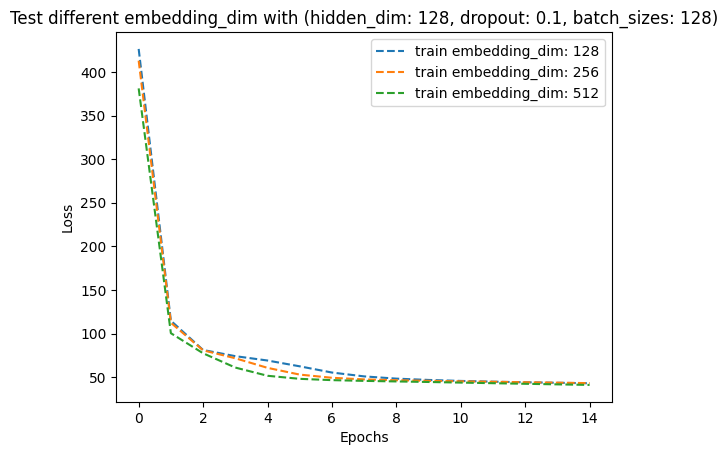

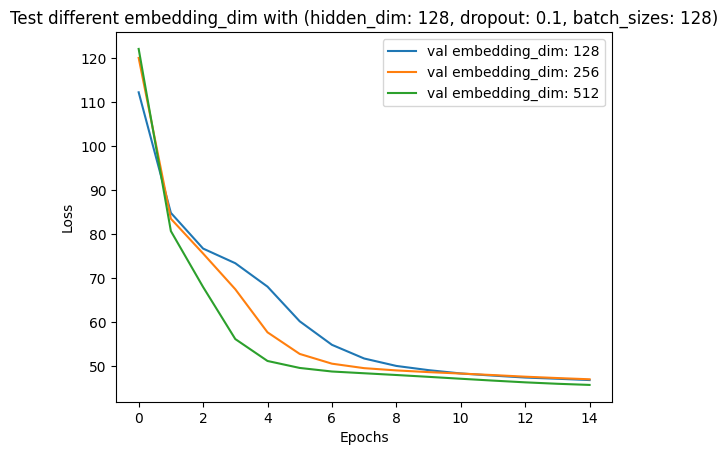

In [51]:
title = f"Test different embedding_dim with (hidden_dim: 128, dropout: 0.1, batch_sizes: 128)"
plot_training_validation_loss_hyperparameters(title, losses, 'embedding_dim', embedding_dims)

Then I choose embedding dim 512 as my best choice

In [52]:
embedding_dims = 512
hidden_dims = [128, 256, 512]
dropout = 0.1
batch_size = 128
losses = []
for hidden_dim in hidden_dims:
    losses_all_epoch = test_hyperparameters(grid_search_train_dataset, grid_search_val_dataset, batch_size, embedding_dim, hidden_dim, dropout, epochs=15)
    losses.append(losses_all_epoch)

Epoch 1, Average Train Loss: 404.36314094640034, Epoch 1, Average Val Loss: 121.69070582970333


Epoch 2, Average Train Loss: 104.21755896459652, Epoch 2, Average Val Loss: 81.81041708927657


Epoch 3, Average Train Loss: 76.59858800187895, Epoch 3, Average Val Loss: 68.01371280143206


Epoch 4, Average Train Loss: 59.5787172727947, Epoch 4, Average Val Loss: 54.0638114252363


Epoch 5, Average Train Loss: 50.24430920564676, Epoch 5, Average Val Loss: 50.601885657554305


Epoch 6, Average Train Loss: 47.565754178204116, Epoch 6, Average Val Loss: 49.275737943606934


Epoch 7, Average Train Loss: 46.38178927264636, Epoch 7, Average Val Loss: 48.81300004203856


Epoch 8, Average Train Loss: 45.7192852551424, Epoch 8, Average Val Loss: 48.5171759227131


Epoch 9, Average Train Loss: 45.16978280755538, Epoch 9, Average Val Loss: 48.19394808170695


Epoch 10, Average Train Loss: 44.59946397226068, Epoch 10, Average Val Loss: 47.82807829048514


Epoch 11, Average Train Loss: 44.067314514932754, Epoch 11, Average Val Loss: 47.46861954699778


Epoch 12, Average Train Loss: 43.54443637509889, Epoch 12, Average Val Loss: 47.17026371636025


Epoch 13, Average Train Loss: 43.04133192617682, Epoch 13, Average Val Loss: 46.870243191976996


Epoch 14, Average Train Loss: 42.53576412925237, Epoch 14, Average Val Loss: 46.57915041286763


Epoch 15, Average Train Loss: 42.07035816047765, Epoch 15, Average Val Loss: 46.30579985373249


Epoch 1, Average Train Loss: 278.8063016094739, Epoch 1, Average Val Loss: 90.0867074285033


Epoch 2, Average Train Loss: 87.18713348002373, Epoch 2, Average Val Loss: 83.20499121193842


Epoch 3, Average Train Loss: 79.09631502175633, Epoch 3, Average Val Loss: 73.8576118270271


Epoch 4, Average Train Loss: 62.65606318606606, Epoch 4, Average Val Loss: 52.96327620092387


Epoch 5, Average Train Loss: 47.96924029000198, Epoch 5, Average Val Loss: 48.90981652168923


Epoch 6, Average Train Loss: 45.46881273486946, Epoch 6, Average Val Loss: 48.06577458722134


Epoch 7, Average Train Loss: 44.14910316950158, Epoch 7, Average Val Loss: 47.434694759993164


Epoch 8, Average Train Loss: 43.12427329534217, Epoch 8, Average Val Loss: 46.834819418791284


Epoch 9, Average Train Loss: 42.122837037678, Epoch 9, Average Val Loss: 46.12479503420026


Epoch 10, Average Train Loss: 41.050546844096125, Epoch 10, Average Val Loss: 45.37320121102202


Epoch 11, Average Train Loss: 39.872343270989916, Epoch 11, Average Val Loss: 44.59647644550379


Epoch 12, Average Train Loss: 38.615524562401106, Epoch 12, Average Val Loss: 44.005569553581594


Epoch 13, Average Train Loss: 37.31964598064181, Epoch 13, Average Val Loss: 43.33697342250847


Epoch 14, Average Train Loss: 36.05182734622231, Epoch 14, Average Val Loss: 43.11381148640353


Epoch 15, Average Train Loss: 34.8823983880538, Epoch 15, Average Val Loss: 42.370974418310844


Epoch 1, Average Train Loss: 201.49373578421677, Epoch 1, Average Val Loss: 78.48435576012841


Epoch 2, Average Train Loss: 62.40087705201741, Epoch 2, Average Val Loss: 52.54346339820173


Epoch 3, Average Train Loss: 46.8633192617682, Epoch 3, Average Val Loss: 47.462031670385635


Epoch 4, Average Train Loss: 43.655229863034016, Epoch 4, Average Val Loss: 46.46558654249943


Epoch 5, Average Train Loss: 42.357752237440664, Epoch 5, Average Val Loss: 46.03500944866758


Epoch 6, Average Train Loss: 41.28541476092761, Epoch 6, Average Val Loss: 45.45409583502377


Epoch 7, Average Train Loss: 40.1737675534019, Epoch 7, Average Val Loss: 44.95590644039688


Epoch 8, Average Train Loss: 39.12116034785404, Epoch 8, Average Val Loss: 44.455837488255895


Epoch 9, Average Train Loss: 37.792039315911786, Epoch 9, Average Val Loss: 43.6611313667293


Epoch 10, Average Train Loss: 36.450583619709256, Epoch 10, Average Val Loss: 43.05264053892104


Epoch 11, Average Train Loss: 35.05391351241099, Epoch 11, Average Val Loss: 42.82123862734526


Epoch 12, Average Train Loss: 33.828618380389635, Epoch 12, Average Val Loss: 42.20799880423642


Epoch 13, Average Train Loss: 32.54817589868473, Epoch 13, Average Val Loss: 42.179280849187876


Epoch 14, Average Train Loss: 31.570809048036985, Epoch 14, Average Val Loss: 41.80083240804009


Epoch 15, Average Train Loss: 30.288455547863926, Epoch 15, Average Val Loss: 41.686186155878104


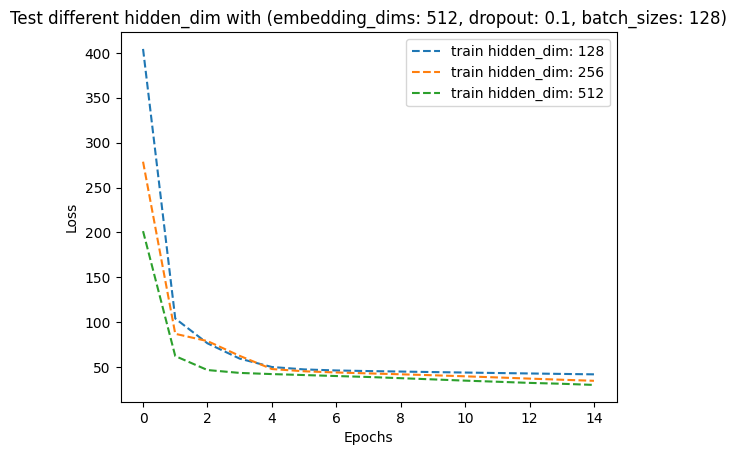

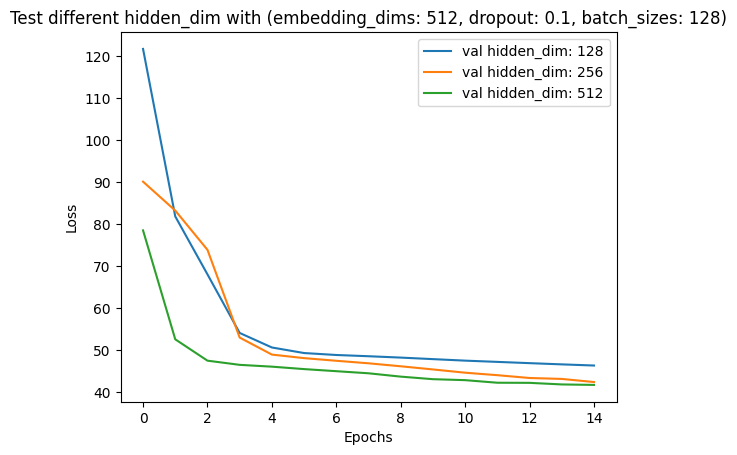

In [53]:
title = f"Test different hidden_dim with (embedding_dims: 512, dropout: 0.1, batch_sizes: 128)"
plot_training_validation_loss_hyperparameters(title, losses, 'hidden_dim', hidden_dims)

I choose 256 as my best hidden choice

In [54]:
embedding_dims = 512
hidden_dims = 256
dropouts = [0.1, 0.2, 0.3, 0.4, 0.5]
batch_size = 128
losses = []
for dropout in dropouts:
    losses_all_epoch = test_hyperparameters(grid_search_train_dataset, grid_search_val_dataset, batch_size, embedding_dim, hidden_dim, dropout, epochs=15)
    losses.append(losses_all_epoch)

Epoch 1, Average Train Loss: 204.0553520878659, Epoch 1, Average Val Loss: 84.31613450071532


Epoch 2, Average Train Loss: 73.87923213137856, Epoch 2, Average Val Loss: 56.24484488214967


Epoch 3, Average Train Loss: 48.930910520915745, Epoch 3, Average Val Loss: 49.42184452760221


Epoch 4, Average Train Loss: 45.587510430058344, Epoch 4, Average Val Loss: 47.925693336020245


Epoch 5, Average Train Loss: 43.658785122255736, Epoch 5, Average Val Loss: 47.34495168567966


Epoch 6, Average Train Loss: 42.51761729566357, Epoch 6, Average Val Loss: 46.715930997368254


Epoch 7, Average Train Loss: 41.39636616767207, Epoch 7, Average Val Loss: 45.96961507133655


Epoch 8, Average Train Loss: 40.11376072364517, Epoch 8, Average Val Loss: 45.11740778540848


Epoch 9, Average Train Loss: 38.67084242422369, Epoch 9, Average Val Loss: 44.449043255679875


Epoch 10, Average Train Loss: 37.222808219813096, Epoch 10, Average Val Loss: 43.700813351670156


Epoch 11, Average Train Loss: 35.82879267825356, Epoch 11, Average Val Loss: 42.5358524441977


Epoch 12, Average Train Loss: 33.97302640118176, Epoch 12, Average Val Loss: 42.17199613890253


Epoch 13, Average Train Loss: 32.22417787962322, Epoch 13, Average Val Loss: 41.24019917604416


Epoch 14, Average Train Loss: 30.24925139221964, Epoch 14, Average Val Loss: 41.35919211000669


Epoch 15, Average Train Loss: 28.47739002855518, Epoch 15, Average Val Loss: 40.32136963641314


Epoch 1, Average Train Loss: 212.46988355419305, Epoch 1, Average Val Loss: 86.57100124291794


Epoch 2, Average Train Loss: 76.809926634197, Epoch 2, Average Val Loss: 58.41084032196646


Epoch 3, Average Train Loss: 50.71103932827334, Epoch 3, Average Val Loss: 49.398502142632175


Epoch 4, Average Train Loss: 45.9148554934731, Epoch 4, Average Val Loss: 48.14958491367192


Epoch 5, Average Train Loss: 44.02101061857199, Epoch 5, Average Val Loss: 47.1784469175279


Epoch 6, Average Train Loss: 42.85935089497627, Epoch 6, Average Val Loss: 46.51295674676681


Epoch 7, Average Train Loss: 41.77195303228837, Epoch 7, Average Val Loss: 45.93115262178283


Epoch 8, Average Train Loss: 40.73309218008307, Epoch 8, Average Val Loss: 45.377519589080826


Epoch 9, Average Train Loss: 39.67914652764043, Epoch 9, Average Val Loss: 44.90997714125313


Epoch 10, Average Train Loss: 38.65287189725079, Epoch 10, Average Val Loss: 44.388476028676976


Epoch 11, Average Train Loss: 37.51921865728837, Epoch 11, Average Val Loss: 43.925791759640845


Epoch 12, Average Train Loss: 36.34726987428303, Epoch 12, Average Val Loss: 43.5050551372459


Epoch 13, Average Train Loss: 35.108332921281644, Epoch 13, Average Val Loss: 42.9694830613505


Epoch 14, Average Train Loss: 33.80691327445115, Epoch 14, Average Val Loss: 42.48243474791987


Epoch 15, Average Train Loss: 32.44059625939478, Epoch 15, Average Val Loss: 42.274632095842584


Epoch 1, Average Train Loss: 202.05677567494067, Epoch 1, Average Val Loss: 83.4592334924126


Epoch 2, Average Train Loss: 73.8961652924743, Epoch 2, Average Val Loss: 59.048558210731976


Epoch 3, Average Train Loss: 50.69649998145768, Epoch 3, Average Val Loss: 48.25458848694981


Epoch 4, Average Train Loss: 44.88537458588805, Epoch 4, Average Val Loss: 46.73965906947529


Epoch 5, Average Train Loss: 43.18250469738924, Epoch 5, Average Val Loss: 46.196188470223355


Epoch 6, Average Train Loss: 42.050816712198376, Epoch 6, Average Val Loss: 45.65187076055546


Epoch 7, Average Train Loss: 40.965451783771755, Epoch 7, Average Val Loss: 45.125421025109254


Epoch 8, Average Train Loss: 39.84467788889438, Epoch 8, Average Val Loss: 44.986875210192814


Epoch 9, Average Train Loss: 38.81299322587025, Epoch 9, Average Val Loss: 44.61661828339419


Epoch 10, Average Train Loss: 38.15687054984177, Epoch 10, Average Val Loss: 43.6600680857907


Epoch 11, Average Train Loss: 36.684894339645965, Epoch 11, Average Val Loss: 43.065164138347356


Epoch 12, Average Train Loss: 35.40189919773536, Epoch 12, Average Val Loss: 42.775512820427274


Epoch 13, Average Train Loss: 34.15143285823774, Epoch 13, Average Val Loss: 42.754103875733115


Epoch 14, Average Train Loss: 33.14127166361748, Epoch 14, Average Val Loss: 42.697807260749414


Epoch 15, Average Train Loss: 31.807057131996636, Epoch 15, Average Val Loss: 41.918459255512616


Epoch 1, Average Train Loss: 204.0010652566258, Epoch 1, Average Val Loss: 82.06453964881563


Epoch 2, Average Train Loss: 73.70466154074367, Epoch 2, Average Val Loss: 59.8019698959401


Epoch 3, Average Train Loss: 51.677314777615706, Epoch 3, Average Val Loss: 48.5910383180393


Epoch 4, Average Train Loss: 45.444996971420096, Epoch 4, Average Val Loss: 46.889470413081156


Epoch 5, Average Train Loss: 43.57057572376879, Epoch 5, Average Val Loss: 46.02378117637691


Epoch 6, Average Train Loss: 42.35670436424545, Epoch 6, Average Val Loss: 45.48436699265459


Epoch 7, Average Train Loss: 41.21736164334454, Epoch 7, Average Val Loss: 44.950396441446735


Epoch 8, Average Train Loss: 40.17864565306072, Epoch 8, Average Val Loss: 44.33585136543033


Epoch 9, Average Train Loss: 39.06578531385977, Epoch 9, Average Val Loss: 43.836166543442516


Epoch 10, Average Train Loss: 37.935088725029665, Epoch 10, Average Val Loss: 42.91325520388481


Epoch 11, Average Train Loss: 36.49407394988627, Epoch 11, Average Val Loss: 41.98754746576415


Epoch 12, Average Train Loss: 35.02983591586729, Epoch 12, Average Val Loss: 41.69578215305062


Epoch 13, Average Train Loss: 33.83152172233485, Epoch 13, Average Val Loss: 40.688381669896295


Epoch 14, Average Train Loss: 31.92507548271855, Epoch 14, Average Val Loss: 39.40308676492569


Epoch 15, Average Train Loss: 29.50784703508208, Epoch 15, Average Val Loss: 38.841240253281235


Epoch 1, Average Train Loss: 204.1432119635087, Epoch 1, Average Val Loss: 80.81978712917093


Epoch 2, Average Train Loss: 73.50142976785008, Epoch 2, Average Val Loss: 59.984658982729044


Epoch 3, Average Train Loss: 52.27908595604232, Epoch 3, Average Val Loss: 48.34384647739081


Epoch 4, Average Train Loss: 45.75767845443532, Epoch 4, Average Val Loss: 46.55649835560265


Epoch 5, Average Train Loss: 43.700116044056564, Epoch 5, Average Val Loss: 45.76979232282414


Epoch 6, Average Train Loss: 42.47362817691851, Epoch 6, Average Val Loss: 45.02365517189991


Epoch 7, Average Train Loss: 41.270173818853834, Epoch 7, Average Val Loss: 44.47322974831134


Epoch 8, Average Train Loss: 40.09412640921677, Epoch 8, Average Val Loss: 43.76201513299311


Epoch 9, Average Train Loss: 38.891493707970724, Epoch 9, Average Val Loss: 43.076272745309474


Epoch 10, Average Train Loss: 37.7301070973843, Epoch 10, Average Val Loss: 42.68925716746384


Epoch 11, Average Train Loss: 36.52898984498616, Epoch 11, Average Val Loss: 41.794596437576516


Epoch 12, Average Train Loss: 35.29896294316159, Epoch 12, Average Val Loss: 41.11255032950226


Epoch 13, Average Train Loss: 34.17709682802611, Epoch 13, Average Val Loss: 40.40146266397264


Epoch 14, Average Train Loss: 32.117001458662976, Epoch 14, Average Val Loss: 39.457129061948386


Epoch 15, Average Train Loss: 30.254176427141022, Epoch 15, Average Val Loss: 38.99960897463273


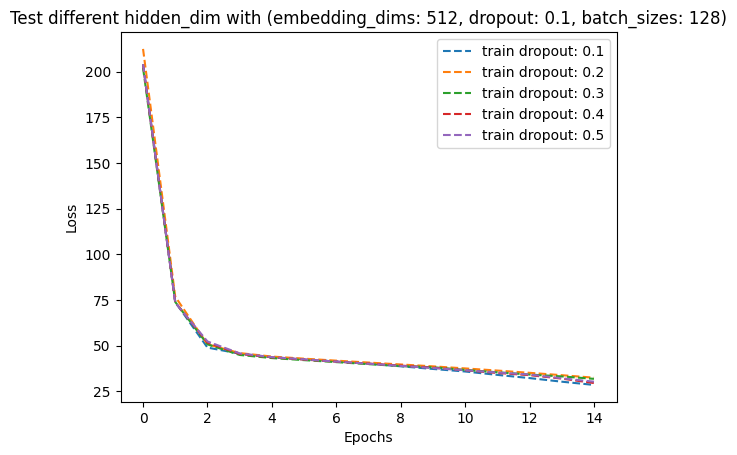

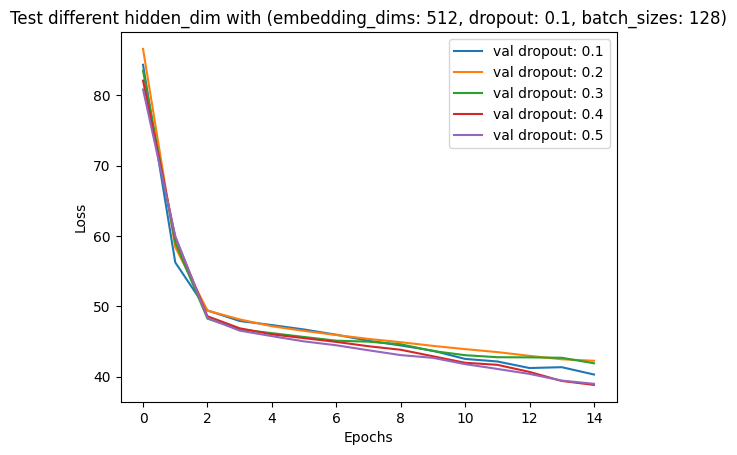

In [56]:
title = f"Test different hidden_dim with (embedding_dims: 512, dropout: 0.1, batch_sizes: 128)"
plot_training_validation_loss_hyperparameters(title, losses, 'dropout', dropouts)

I choose dropout 0.5 as my best choice